In [172]:
import os
import random
import torchaudio
import torch
from concurrent.futures import ProcessPoolExecutor, as_completed
from pprint import pprint
from tqdm import tqdm
import time
import numpy as np
from scipy import signal
from transformers import AutoFeatureExtractor
import matplotlib.pyplot as plt



In [173]:
#create a file with names of cricket audio file: raw data (later to be used to shuffle and use them as train and test data)
wav_dir = "/gpfs/proj1/choe_lab/tanu/Species_classification/raw_audio/species_in_gryllus_genus/"
wav_files_list = sorted(os.listdir(wav_dir))


#Preprocess the data


In [174]:
torch.set_num_threads(1)
SR = 16000
SECONDS_TO_OVERLAP = 5
SECONDS_TO_TRIM= 10
NUM_PROCESS = 8

In [175]:
# load the model and utilities for VAD ( voice activity detection)
def get_model_and_utils():
    model, utils = torch.hub.load(repo_or_dir='snakers4/silero-vad',
                                   model='silero_vad',
                                   force_reload=False,
                                   onnx=False,
                                   verbose=False)
    return model, utils

In [48]:
#load the 'silero_vad' model and its associated utilities
model, utils = get_model_and_utils()
(get_speech_timestamps, save_audio, read_audio, VADIterator, collect_chunks) = utils


In [6]:
#determine the label of the audio files. Adding Gryllus in front of the species as they are the species from Gryllus Genus.
def determine_label_name(wav_file):
    text_after_G = wav_file.split("G. ")[1]
    species = text_after_G.split(" ")[0]
    if species.find(".wav") != -1 or species.find(".WAV") != -1:
      species = species[:-4]

    return ("Gryllus " + species )

In [73]:
# label = determine_label_name("R00-007_208127_G. lineaticeps.wav")
# print(label)

In [7]:
#Load the audio wav file based on the wav file name passed
def load_wav_file(wav_file):
    wav, sample_rate = torchaudio.load(os.path.join(wav_dir, wav_file))
    wav = wav.mean(dim=0) if wav.ndim > 1 else wav
    if sample_rate != 16000:
        resample_transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
        wav = resample_transform(wav)
    return wav


In [8]:
# resample the audio files by extracting 10 secs audio with overlapping 5 secs.
def extract_data_chunks(wav, label_name):
    data = []
    for i in range(0, len(wav), SECONDS_TO_OVERLAP * SR):
        if i + SECONDS_TO_TRIM * SR < len(wav):
            waveform = wav[i: i + SECONDS_TO_TRIM * SR]
            data.append({"array": waveform.squeeze().numpy(), "label": label_name})
        else:
            waveform = wav[i: len(wav)]
            if len(waveform) < 10 * SR:    # 10 here is the seconds to trim
                continue
            else:
                data.append({"array": waveform.squeeze().numpy(), "label": label_name})
    return data

In [9]:
# remove the chunks(the timestamps of audio) where human voice is detected
def drop_chunks(tss, wav):
    if len(tss) == 0:
        return wav
    chunks = []
    cur_start = 0
    for i in tss:
        chunks.append((wav[cur_start: i['start']]))
        cur_start = i['end']
    # Append the remaining part of the wav tensor after the last segment
    chunks.append(wav[cur_start:])
    return torch.cat(chunks)

In [9]:
# Preprocess the wav files
def process_wav_file(wav_file: str):
    # print("Processing file: " + wav_file)
    model, utils = get_model_and_utils()
    (get_speech_timestamps, save_audio, read_audio, VADIterator, collect_chunks) = utils

    label_name = determine_label_name(wav_file)
    wav = load_wav_file(wav_file)
    with torch.no_grad():
        speech_timestamps = get_speech_timestamps(wav, model, sampling_rate=SR)
    final_wav = drop_chunks(speech_timestamps, wav)
    if(len(final_wav) < 1 * SR):
        print("Getting no data from : ",wav_file)
    wav = final_wav[SR:-SR]

    return extract_data_chunks(wav, label_name)
    

In [10]:
# The wav file names are stored in a text file. The wav file names are read from this file for further processing in audio files
#Train and test text files are created separately
def read_wav_files_from_txt_file(txt_file):
    with open(txt_file, 'r') as file:
        wav_files = [line.strip() for line in file.readlines()]
    return wav_files

In [12]:
#preprocess the data VAD preprocessing (to remove human voice over)
def preprocess_data(data_path):
    futures = []
    data = []
    wav_files_list = read_wav_files_from_txt_file(data_path)
    print(len(wav_files_list))
    with ProcessPoolExecutor(max_workers=NUM_PROCESS) as ex:
        for wav_file in wav_files_list:
            futures.append(ex.submit(process_wav_file, wav_file))
    
        for finished in tqdm(as_completed(futures), total=len(futures), desc="Processing WAV files"):
            result = finished.result()
            data.extend(result)
            
    return data

In [188]:
#adding band pass filter to the VAD processed waveforms (to remove any extra noise like phone ringing)
#example 'R01-064_208545_G. leei.wav'

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

In [189]:
def filter_data_noise(data):
    all_filtered_samples = []
    for i in tqdm(range(len(data))):
      waveform = data[i]['array']
      filtered = butter_highpass_filter(waveform,2000,SR)
      filtered_samples = {'array': filtered,'label':data[i]['label']}
      all_filtered_samples.append(filtered_samples)

    return all_filtered_samples

In [190]:
#preprocess train data for 5_species
train_path = r'/gpfs/proj1/choe_lab/tanu/Species_classification/raw_data/5_species/train.txt'
data_train = preprocess_data(train_path)
pprint(len(data_train))

380


Processing WAV files:   0%|                             | 0/380 [00:00<?, ?it/s]/gpfs/proj1/choe_lab/tanu/venv/jupyter/lib/python3.8/site-packages/torch/nn/modules/module.py:1501: UserWarning: operator() profile_node %669 : int[] = prim::profile_ivalue(%667)
 does not have profile information (Triggered internally at ../third_party/nvfuser/csrc/graph_fuser.cpp:104.)
  return forward_call(*args, **kwargs)
/gpfs/proj1/choe_lab/tanu/venv/jupyter/lib/python3.8/site-packages/torch/nn/modules/module.py:1501: UserWarning: operator() profile_node %669 : int[] = prim::profile_ivalue(%667)
 does not have profile information (Triggered internally at ../third_party/nvfuser/csrc/graph_fuser.cpp:104.)
  return forward_call(*args, **kwargs)
/gpfs/proj1/choe_lab/tanu/venv/jupyter/lib/python3.8/site-packages/torch/nn/modules/module.py:1501: UserWarning: operator() profile_node %669 : int[] = prim::profile_ivalue(%667)
 does not have profile information (Triggered internally at ../third_party/nvfuser/cs

3130


In [165]:
#preprocess train data for 3_species
train_path = r'/gpfs/proj1/choe_lab/tanu/Species_classification/raw_data/3_species/train_new.txt'
data_train = preprocess_data(train_path)
pprint(len(data_train))

285


Processing WAV files:   0%|                             | 0/285 [00:00<?, ?it/s]/gpfs/proj1/choe_lab/tanu/venv/jupyter/lib/python3.8/site-packages/torch/nn/modules/module.py:1501: UserWarning: operator() profile_node %669 : int[] = prim::profile_ivalue(%667)
 does not have profile information (Triggered internally at ../third_party/nvfuser/csrc/graph_fuser.cpp:104.)
  return forward_call(*args, **kwargs)
/gpfs/proj1/choe_lab/tanu/venv/jupyter/lib/python3.8/site-packages/torch/nn/modules/module.py:1501: UserWarning: operator() profile_node %669 : int[] = prim::profile_ivalue(%667)
 does not have profile information (Triggered internally at ../third_party/nvfuser/csrc/graph_fuser.cpp:104.)
  return forward_call(*args, **kwargs)
/gpfs/proj1/choe_lab/tanu/venv/jupyter/lib/python3.8/site-packages/torch/nn/modules/module.py:1501: UserWarning: operator() profile_node %669 : int[] = prim::profile_ivalue(%667)
 does not have profile information (Triggered internally at ../third_party/nvfuser/cs

2319


In [54]:
#preprocess train data
train_path = r'/gpfs/proj1/choe_lab/tanu/Species_classification/raw_data/old_data/train_old.txt'
data_train = preprocess_data(train_path)
pprint(len(data_train))


462


Processing WAV files:   0%|                             | 0/462 [00:00<?, ?it/s]/gpfs/proj1/choe_lab/tanu/venv/jupyter/lib/python3.8/site-packages/torch/nn/modules/module.py:1501: UserWarning: operator() profile_node %669 : int[] = prim::profile_ivalue(%667)
 does not have profile information (Triggered internally at ../third_party/nvfuser/csrc/graph_fuser.cpp:104.)
  return forward_call(*args, **kwargs)
/gpfs/proj1/choe_lab/tanu/venv/jupyter/lib/python3.8/site-packages/torch/nn/modules/module.py:1501: UserWarning: operator() profile_node %669 : int[] = prim::profile_ivalue(%667)
 does not have profile information (Triggered internally at ../third_party/nvfuser/csrc/graph_fuser.cpp:104.)
  return forward_call(*args, **kwargs)
/gpfs/proj1/choe_lab/tanu/venv/jupyter/lib/python3.8/site-packages/torch/nn/modules/module.py:1501: UserWarning: operator() profile_node %669 : int[] = prim::profile_ivalue(%667)
 does not have profile information (Triggered internally at ../third_party/nvfuser/cs

3701


In [191]:

print(data_train[0])
print(data_train[0]['array'].shape)

{'array': array([ 0.05536535,  0.00632829,  0.02543316, ..., -0.02059298,
       -0.00966915,  0.01276176], dtype=float32), 'label': 'Gryllus lineaticeps'}
(160000,)


In [192]:
#filter the extra data noise on top of VAD processing (for 5 species)
filtered_data_train = filter_data_noise(data_train)
print(len(filtered_data_train))
print(filtered_data_train[0])

100%|██████████████████████████████████████| 3130/3130 [00:12<00:00, 243.37it/s]

3130
{'array': array([-3.51467450e-05, -3.68686740e-02, -8.27945688e-03, ...,
       -1.57206230e-02, -1.24674633e-02,  7.38511965e-05]), 'label': 'Gryllus lineaticeps'}


In [167]:
#filter the extra data noise on top of VAD processing (for 3 species)
filtered_data_train = filter_data_noise(data_train)
print(len(filtered_data_train))
print(filtered_data_train[0])

100%|██████████████████████████████████████| 2319/2319 [00:08<00:00, 258.21it/s]

2319
{'array': array([ 5.74251133e-06, -2.06482911e-03, -2.43777575e-04, ...,
       -5.82106503e-03, -1.83608261e-03,  9.38901238e-06]), 'label': 'Gryllus lineaticeps'}


In [59]:
#filter the extra data noise on top of VAD processing
filtered_data_train = filter_data_noise(data_train)
print(len(filtered_data_train))
print(filtered_data_train[0])

100%|██████████████████████████████████████| 3701/3701 [00:13<00:00, 275.27it/s]

3701
{'array': array([-7.89890602e-09,  9.00843817e-08, -7.21619656e-07, ...,
        2.33604901e-01, -3.66769979e-02,  5.30944968e-03]), 'label': 'Gryllus lineaticeps'}


In [193]:
#save the train VAD and band pass filtered data as .pt(pickle file) - 5 species
save_dir_train = r"/gpfs/proj1/choe_lab/tanu/Species_classification/VAD_processed/5_species/train/"
torch.save(filtered_data_train, save_dir_train + "data.pt")

In [168]:
#save the train VAD and band pass filtered data as .pt(pickle file) - 3 species
save_dir_train = r"/gpfs/proj1/choe_lab/tanu/Species_classification/VAD_processed/3_species/train_new/"
torch.save(filtered_data_train, save_dir_train + "data.pt")

In [60]:
#save the train VAD and band pass filtered data as .pt(pickle file) - 9 species
save_dir_train = r"/gpfs/proj1/choe_lab/tanu/Species_classification/VAD_processed/with_band_pass_filter/train/"
torch.save(filtered_data_train, save_dir_train + "data.pt")

In [194]:
#for 5-species
#preprocess test data (both VAD and band pass filter)
test_path = r'/gpfs/proj1/choe_lab/tanu/Species_classification/raw_data/5_species/test.txt'
data_test = preprocess_data(test_path)
pprint(len(data_test))

#filter the extra data noise on top of VAD processing
filtered_data_test = filter_data_noise(data_test)
print(len(filtered_data_test))
print(filtered_data_test[0])

#save the test VAD and band pass filtered data as .pt(pickle file)
save_dir_test = r"/gpfs/proj1/choe_lab/tanu/Species_classification/VAD_processed/5_species/test/"
torch.save(filtered_data_test, save_dir_test + "data.pt")


98


Processing WAV files:   0%|                              | 0/98 [00:00<?, ?it/s]/gpfs/proj1/choe_lab/tanu/venv/jupyter/lib/python3.8/site-packages/torch/nn/modules/module.py:1501: UserWarning: operator() profile_node %669 : int[] = prim::profile_ivalue(%667)
 does not have profile information (Triggered internally at ../third_party/nvfuser/csrc/graph_fuser.cpp:104.)
  return forward_call(*args, **kwargs)
/gpfs/proj1/choe_lab/tanu/venv/jupyter/lib/python3.8/site-packages/torch/nn/modules/module.py:1501: UserWarning: operator() profile_node %669 : int[] = prim::profile_ivalue(%667)
 does not have profile information (Triggered internally at ../third_party/nvfuser/csrc/graph_fuser.cpp:104.)
  return forward_call(*args, **kwargs)
/gpfs/proj1/choe_lab/tanu/venv/jupyter/lib/python3.8/site-packages/torch/nn/modules/module.py:1501: UserWarning: operator() profile_node %669 : int[] = prim::profile_ivalue(%667)
 does not have profile information (Triggered internally at ../third_party/nvfuser/cs

797


100%|████████████████████████████████████████| 797/797 [00:03<00:00, 263.16it/s]


797
{'array': array([-5.77729787e-06,  2.53500756e-03,  2.36854202e-03, ...,
        4.92633476e-04, -1.80305273e-04, -5.53986734e-06]), 'label': 'Gryllus lineaticeps'}


In [169]:
#for 3-species
#preprocess test data (both VAD and band pass filter)
test_path = r'/gpfs/proj1/choe_lab/tanu/Species_classification/raw_data/3_species/test_new.txt'
data_test = preprocess_data(test_path)
pprint(len(data_test))

#filter the extra data noise on top of VAD processing
filtered_data_test = filter_data_noise(data_test)
print(len(filtered_data_test))
print(filtered_data_test[0])

#save the test VAD and band pass filtered data as .pt(pickle file)
save_dir_test = r"/gpfs/proj1/choe_lab/tanu/Species_classification/VAD_processed/3_species/test_new/"
torch.save(filtered_data_test, save_dir_test + "data.pt")


73


Processing WAV files:   0%|                              | 0/73 [00:00<?, ?it/s]/gpfs/proj1/choe_lab/tanu/venv/jupyter/lib/python3.8/site-packages/torch/nn/modules/module.py:1501: UserWarning: operator() profile_node %669 : int[] = prim::profile_ivalue(%667)
 does not have profile information (Triggered internally at ../third_party/nvfuser/csrc/graph_fuser.cpp:104.)
  return forward_call(*args, **kwargs)
/gpfs/proj1/choe_lab/tanu/venv/jupyter/lib/python3.8/site-packages/torch/nn/modules/module.py:1501: UserWarning: operator() profile_node %669 : int[] = prim::profile_ivalue(%667)
 does not have profile information (Triggered internally at ../third_party/nvfuser/csrc/graph_fuser.cpp:104.)
  return forward_call(*args, **kwargs)
/gpfs/proj1/choe_lab/tanu/venv/jupyter/lib/python3.8/site-packages/torch/nn/modules/module.py:1501: UserWarning: operator() profile_node %669 : int[] = prim::profile_ivalue(%667)
 does not have profile information (Triggered internally at ../third_party/nvfuser/cs

551


100%|████████████████████████████████████████| 551/551 [00:02<00:00, 253.39it/s]


551
{'array': array([ 7.46568066e-06, -1.96181131e-03,  1.15493575e-03, ...,
       -9.96437020e-06, -3.66399586e-06, -6.51707228e-08]), 'label': 'Gryllus lineaticeps'}


In [69]:
#preprocess test data (both VAD and band pass filter)
test_path = r'/gpfs/proj1/choe_lab/tanu/Species_classification/raw_data/old_data/test_old.txt'
data_test = preprocess_data(test_path)
pprint(len(data_test))

#filter the extra data noise on top of VAD processing
filtered_data_test = filter_data_noise(data_test)
print(len(filtered_data_test))
print(filtered_data_test[0])

#save the test VAD and band pass filtered data as .pt(pickle file)
save_dir_test = r"/gpfs/proj1/choe_lab/tanu/Species_classification/VAD_processed/with_band_pass_filter/test/"
torch.save(filtered_data_test, save_dir_test + "data.pt")


120


Processing WAV files:   0%|                             | 0/120 [00:00<?, ?it/s]/gpfs/proj1/choe_lab/tanu/venv/jupyter/lib/python3.8/site-packages/torch/nn/modules/module.py:1501: UserWarning: operator() profile_node %669 : int[] = prim::profile_ivalue(%667)
 does not have profile information (Triggered internally at ../third_party/nvfuser/csrc/graph_fuser.cpp:104.)
  return forward_call(*args, **kwargs)
/gpfs/proj1/choe_lab/tanu/venv/jupyter/lib/python3.8/site-packages/torch/nn/modules/module.py:1501: UserWarning: operator() profile_node %669 : int[] = prim::profile_ivalue(%667)
 does not have profile information (Triggered internally at ../third_party/nvfuser/csrc/graph_fuser.cpp:104.)
  return forward_call(*args, **kwargs)
/gpfs/proj1/choe_lab/tanu/venv/jupyter/lib/python3.8/site-packages/torch/nn/modules/module.py:1501: UserWarning: operator() profile_node %669 : int[] = prim::profile_ivalue(%667)
 does not have profile information (Triggered internally at ../third_party/nvfuser/cs

Getting no data from :  R00-060_208180_G. fultoni.wav


Processing WAV files: 100%|███████████████████| 120/120 [00:46<00:00,  2.59it/s]


988


100%|████████████████████████████████████████| 988/988 [00:03<00:00, 290.61it/s]


988
{'array': array([ 7.46568066e-06, -1.96181131e-03,  1.15493575e-03, ...,
       -9.96437020e-06, -3.66399586e-06, -6.51707228e-08]), 'label': 'Gryllus lineaticeps'}


#Feature extraction

In [14]:
# %%capture
# pip install transformers

In [3]:
feature_extractor = AutoFeatureExtractor.from_pretrained(
    "MIT/ast-finetuned-audioset-10-10-0.4593"
)

In [4]:
def process_samples_in_batches(samples, batch_size):
    all_processed_samples = []
    num_samples = len(samples)
    print("number of samples", num_samples)
    num_batches = int(np.ceil(num_samples / float(batch_size)))
    print("number of batches", num_batches)

    for i in tqdm(range(num_batches), desc="Processing batches"):
        start = i * batch_size
        end = min(start + batch_size, num_samples)
        batch_samples = samples[start:end]

        arrays = [sample['array'] for sample in batch_samples]
        inputs = feature_extractor(
            arrays, sampling_rate=16000, return_tensors="np"
        )
        for input_values, sample in zip(inputs['input_values'], batch_samples):
            processed_sample = {
                'array': input_values,
                'label': sample['label']
            }
            all_processed_samples.append(processed_sample)
    return all_processed_samples




In [5]:
def main(input_dir, output_dir, batch_size=16):
    samples = torch.load(input_dir)
    all_processed_samples = process_samples_in_batches(samples, batch_size)
    print("len of all_processed_samples: ", len(all_processed_samples))
    print("shape of all_processed_samples: ", all_processed_samples[0]['array'].shape, all_processed_samples[0]['label'])
    torch.save(all_processed_samples, output_dir + 'cricket_data_feature_extracted.pt')



In [198]:
#5 species
#features extracted for train data(VAD processed + band pass filter)
datapath_train = r"/gpfs/proj1/choe_lab/tanu/Species_classification/VAD_processed/5_species/train/data.pt"
outputpath_train = r"/gpfs/proj1/choe_lab/tanu/Species_classification/features_extracted/5_species/train/"
batch_size = 16
main(datapath_train, outputpath_train, batch_size)

number of samples 3130
number of batches 196


Processing batches: 100%|█████████████████████| 196/196 [00:27<00:00,  7.18it/s]


len of all_processed_samples:  3130
shape of all_processed_samples:  (1024, 128) Gryllus lineaticeps


In [199]:
#5 species
#features extracted for test data(VAD process + band pass filter)
datapath_test = r"/gpfs/proj1/choe_lab/tanu/Species_classification/VAD_processed/5_species/test/data.pt"
outputpath_test = r"/gpfs/proj1/choe_lab/tanu/Species_classification/features_extracted/5_species/test/"
batch_size = 16
main(datapath_test, outputpath_test, batch_size)

number of samples 797
number of batches 50


Processing batches: 100%|███████████████████████| 50/50 [00:05<00:00,  8.87it/s]


len of all_processed_samples:  797
shape of all_processed_samples:  (1024, 128) Gryllus lineaticeps


In [6]:
#trial if we have correct data
#3 species
#features extracted for train data(VAD processed + band pass filter)
datapath_train = r"/gpfs/proj1/choe_lab/tanu/Species_classification/VAD_processed/3_species/train/data.pt"
outputpath_train = r"/gpfs/proj1/choe_lab/tanu/Species_classification/features_extracted/3_species/train/"
batch_size = 16
main(datapath_train, outputpath_train, batch_size)

number of samples 2273
number of batches 143


Processing batches: 100%|█████████████████████| 143/143 [00:11<00:00, 12.32it/s]


len of all_processed_samples:  2273
shape of all_processed_samples:  (1024, 128) Gryllus lineaticeps


In [7]:
#trail if correct test data
#3 species
#features extracted for test data(VAD process + band pass filter)
datapath_test = r"/gpfs/proj1/choe_lab/tanu/Species_classification/VAD_processed/3_species/test/data.pt"
outputpath_test = r"/gpfs/proj1/choe_lab/tanu/Species_classification/features_extracted/3_species/test/"
batch_size = 16
main(datapath_test, outputpath_test, batch_size)

number of samples 597
number of batches 38


Processing batches: 100%|███████████████████████| 38/38 [00:02<00:00, 12.78it/s]


len of all_processed_samples:  597
shape of all_processed_samples:  (1024, 128) Gryllus lineaticeps


In [73]:
#features extracted for train data(VAD processed + band pass filter)
datapath_train = r"/gpfs/proj1/choe_lab/tanu/Species_classification/VAD_processed/with_band_pass_filter/train/data.pt"
outputpath_train = r"/gpfs/proj1/choe_lab/tanu/Species_classification/features_extracted/with_band_pass_filter/train/"
batch_size = 16
main(datapath_train, outputpath_train, batch_size)

number of samples 3701
number of batches 232


Processing batches: 100%|█████████████████████| 232/232 [00:24<00:00,  9.53it/s]


len of all_processed_samples:  3701
shape of all_processed_samples:  (1024, 128) Gryllus lineaticeps


In [74]:
#features extracted for test data(VAD process + band pass filter)
datapath_test = r"/gpfs/proj1/choe_lab/tanu/Species_classification/VAD_processed/with_band_pass_filter/test/data.pt"
outputpath_test = r"/gpfs/proj1/choe_lab/tanu/Species_classification/features_extracted/with_band_pass_filter/test/"
batch_size = 16
main(datapath_test, outputpath_test, batch_size)

number of samples 988
number of batches 62


Processing batches: 100%|███████████████████████| 62/62 [00:04<00:00, 13.57it/s]


len of all_processed_samples:  988
shape of all_processed_samples:  (1024, 128) Gryllus lineaticeps


In [21]:
# #features extracted for raw data
# data_path_raw = r"/gpfs/proj1/choe_lab/tanu/Species_classification/VAD_processed/raw_data/data.pt"
# output_path_raw = r"/gpfs/proj1/choe_lab/tanu/Species_classification/features_extracted/raw_data/"
# batch_size = 16
# main(data_path_raw, output_path_raw, batch_size)

number of samples 4775
number of batches 299


Processing batches: 100%|█████████████████████| 299/299 [00:24<00:00, 12.10it/s]


len of all_processed_samples:  4775
shape of all_processed_samples:  (1024, 128) Gryllus fultoni


In [39]:
# #features extracted for train data(only VAD processed)
# data_path_train = r"/gpfs/proj1/choe_lab/tanu/Species_classification/VAD_processed/old_data/train/data.pt"
# output_path_train = r"/gpfs/proj1/choe_lab/tanu/Species_classification/features_extracted/old_data/train/"
# batch_size = 16
# main(data_path_train, output_path_train, batch_size)

number of samples 3701
number of batches 232


Processing batches: 100%|█████████████████████| 232/232 [00:17<00:00, 13.24it/s]


len of all_processed_samples:  3701
shape of all_processed_samples:  (1024, 128) Gryllus lineaticeps


In [40]:
# #features extracted for test data(only VAD process)
# data_path_test = r"/gpfs/proj1/choe_lab/tanu/Species_classification/VAD_processed/old_data/test/data.pt"
# output_path_test = r"/gpfs/proj1/choe_lab/tanu/Species_classification/features_extracted/old_data/test/"
# batch_size = 16
# main(data_path_test, output_path_test, batch_size)

number of samples 988
number of batches 62


Processing batches: 100%|███████████████████████| 62/62 [00:04<00:00, 14.30it/s]


len of all_processed_samples:  988
shape of all_processed_samples:  (1024, 128) Gryllus lineaticeps


In [ ]:
#Save the images

In [176]:
data_path_features = r"/gpfs/proj1/choe_lab/tanu/Species_classification/features_extracted/9_species/with_band_pass_filter/train/cricket_data_feature_extracted.pt"
samples = torch.load(data_path_features)


In [3]:
data_path_features_VADonly = r"/gpfs/proj1/choe_lab/tanu/Species_classification/features_extracted/9_species/Only_VAD/train/cricket_data_feature_extracted.pt"
samples_VADonly = torch.load(data_path_features_VADonly)


In [6]:
print(samples_VADonly[1500])

{'array': array([[-0.16298427, -0.55051583, -0.17369343, ..., -0.07596644,
        -0.18593137, -0.08418915],
       [-0.13698363, -0.4998543 , -0.12303188, ..., -0.45417404,
        -0.4131988 , -0.40853226],
       [-0.14888687, -0.46934986, -0.09252749, ..., -0.1619126 ,
        -0.1558781 ,  0.03810937],
       ...,
       [ 0.46703237,  0.46703237,  0.46703237, ...,  0.46703237,
         0.46703237,  0.46703237],
       [ 0.46703237,  0.46703237,  0.46703237, ...,  0.46703237,
         0.46703237,  0.46703237],
       [ 0.46703237,  0.46703237,  0.46703237, ...,  0.46703237,
         0.46703237,  0.46703237]], dtype=float32), 'label': 'Gryllus leei'}


(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120., 140.]),
 [Text(0, -20.0, '−20'),
  Text(0, 0.0, '0'),
  Text(0, 20.0, '20'),
  Text(0, 40.0, '40'),
  Text(0, 60.0, '60'),
  Text(0, 80.0, '80'),
  Text(0, 100.0, '100'),
  Text(0, 120.0, '120'),
  Text(0, 140.0, '140')])

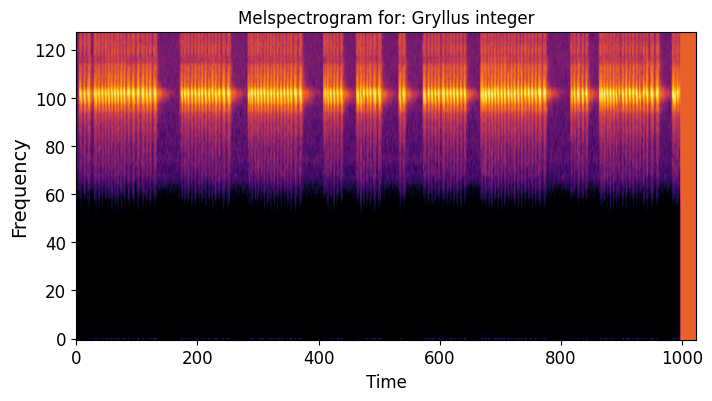

In [196]:
plt.figure(figsize=(8, 4))
plt.imshow(samples[1309]['array'].T, cmap='inferno', aspect='auto', origin='lower')
plt.title(f"Melspectrogram for: {samples[1309]['label']}")
plt.xlabel('Time',fontsize=12)
plt.ylabel('Frequency',fontsize=14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

# plt.savefig('Mel spec of Firmus 1004',dpi=100)

Text(0, 0.5, 'Frequency')

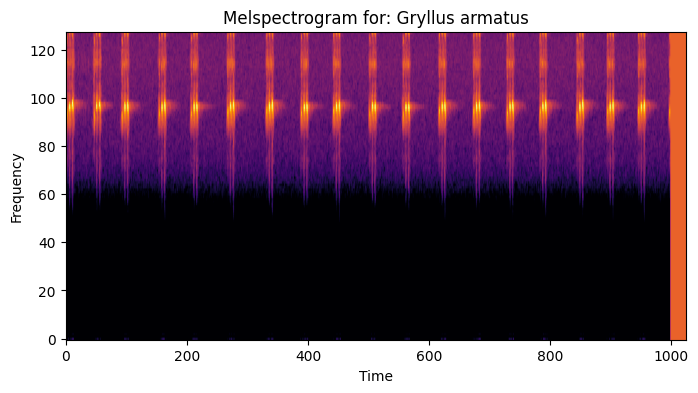

In [171]:
plt.figure(figsize=(8, 4))
plt.imshow(samples[2930]['array'].T, cmap='inferno', aspect='auto', origin='lower')
plt.title(f"Melspectrogram for: {samples[2930]['label']}")
plt.xlabel('Time')
plt.ylabel('Frequency')

NameError: name 'samples_VADonly' is not defined

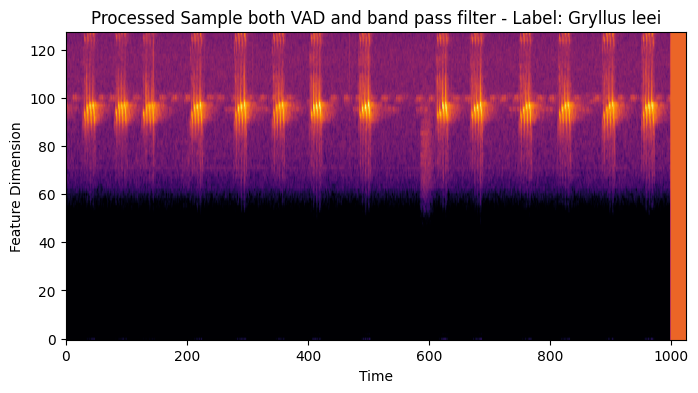

<Figure size 800x400 with 0 Axes>

In [105]:
#plot and save the spectrogram image files



# #Plot the processed sample
plt.figure(figsize=(8, 4))
plt.imshow(samples[1500]['array'].T, cmap='inferno', aspect='auto', origin='lower')
plt.title(f"Processed Sample both VAD and band pass filter - Label: {samples[1500]['label']}")
plt.xlabel('Time')
plt.ylabel('Feature Dimension')

# #Plot the processed sample
plt.figure(figsize=(8, 4))
plt.imshow(samples_VADonly[1500]['array'].T, cmap='inferno', aspect='auto', origin='lower')
plt.title(f"Processed Sample VAD only - Label: {samples_VADonly[1500]['label']}")
plt.xlabel('Time')
plt.ylabel('Feature Dimension')


Text(0, 0.5, 'Feature Dimension')

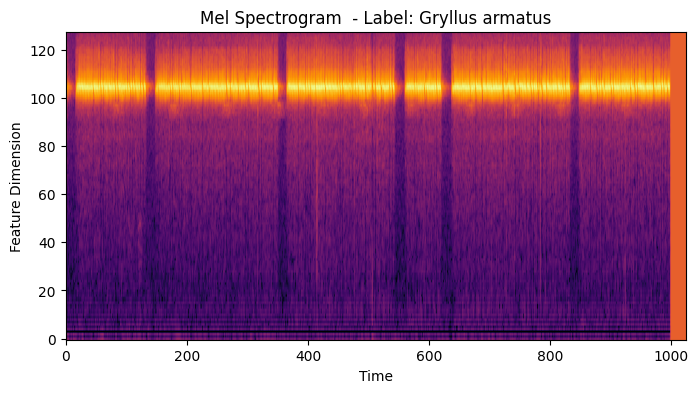

In [31]:
plt.figure(figsize=(8, 4))
plt.imshow(samples_VADonly[3010]['array'].T, cmap='inferno', aspect='auto', origin='lower')
plt.title(f"Mel Spectrogram  - Label: {samples_VADonly[3010]['label']}")
plt.xlabel('Time')
plt.ylabel('Feature Dimension')

In [84]:
image_output_dir = "./mel_images/armatus/"
for idx, sample in enumerate(samples):
    # Plot the processed sample
    if sample['label'] == 'Gryllus armatus' and (idx > 465 and idx <= 480):
        plt.figure(figsize=(8, 4))
        plt.imshow(sample['array'].T, cmap='inferno', aspect='auto', origin='lower')
        plt.title(f"Processed Sample {idx} - Label: {sample['label']}")
        plt.xlabel('Time')
        plt.ylabel('Feature Dimension')

        #Save the plotted image
        image_path = os.path.join(image_output_dir, f"processed_sample_{idx}_{sample['label']}.png")
        plt.savefig(image_path)
        plt.close()



In [ ]:
samples_VADonly

In [33]:
image_output_dir = "./mel_images/9species/lineaticeps/"
for idx, sample in enumerate(samples_VADonly):
    # Plot the processed sample
    if sample['label'] == 'Gryllus lineaticeps':
        plt.figure(figsize=(8, 4))
        plt.imshow(sample['array'].T, cmap='inferno', aspect='auto', origin='lower')
        plt.title(f"Processed Sample {idx} - Label: {sample['label']}")
        plt.xlabel('Time')
        plt.ylabel('Feature Dimension')

        #Save the plotted image
        image_path = os.path.join(image_output_dir, f"processed_sample_{idx}_{sample['label']}.png")
        plt.savefig(image_path)
        plt.close()
